# DL-TDDFT Test

## DL-$h_{eff}(t)$ mapping test $h(t) \rightarrow h_{eff}(t)$

### Test the prediction of the model

#### Imports

In [1]:
import torch
import numpy as np
from numpy.fft import fft,ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List


#### Parameters

In [6]:
data_fourier=np.load('data/dataset_h_eff/train_dataset_fourier_format_240229_ndata_20000.npz')

nbatch=100

h_fft=data_fourier['h']
h_eff_fft=data_fourier['potential']

h_fft_torch=torch.tensor(h_fft[:nbatch])

model=torch.load('model_rep/kohm_sham/cnn_field2field/REDENT2D_fourier_field2field_time_steps_200_tf_20_240228_dataset_[40, 40, 40, 40]_hc_[15, 5]_ks_1_ps_4_nconv_1_nblock',map_location='cpu')
model.eval()

h_eff_fft_reconstruction=model(h_fft_torch).detach().numpy()



#### Test in the fourier space

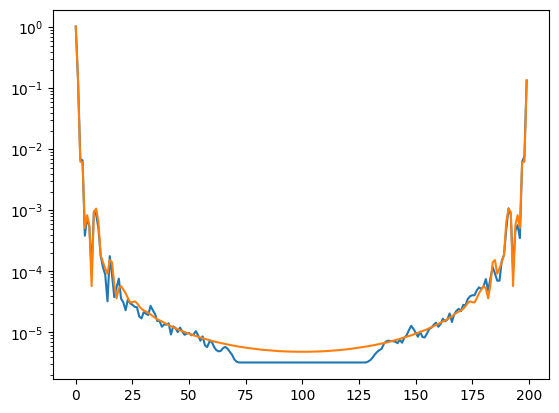

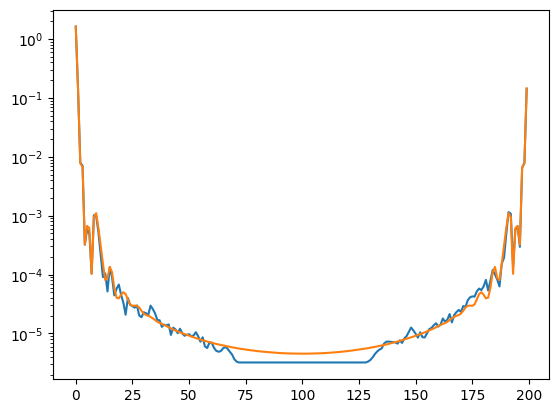

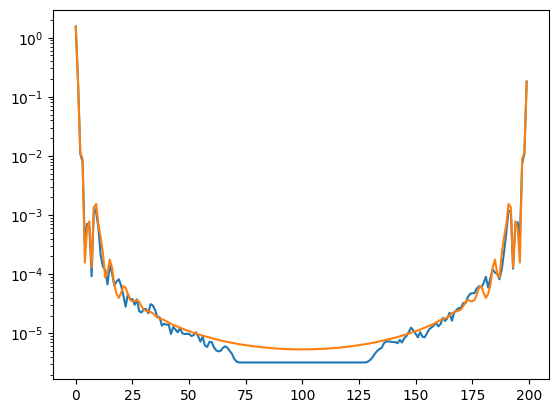

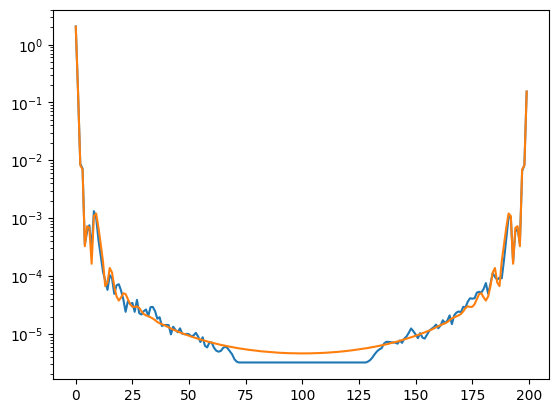

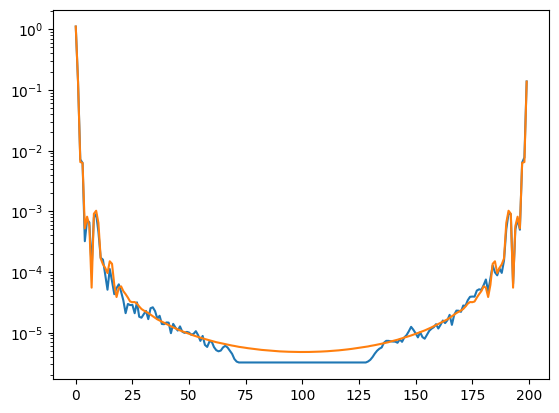

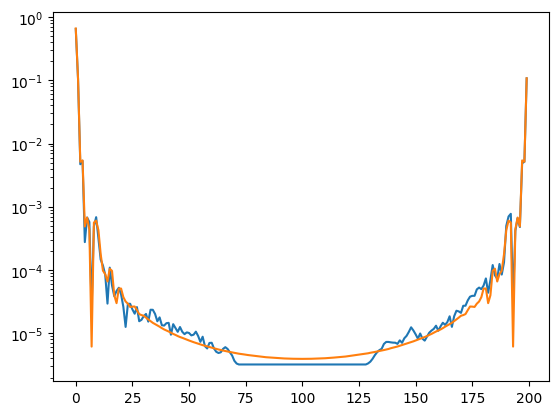

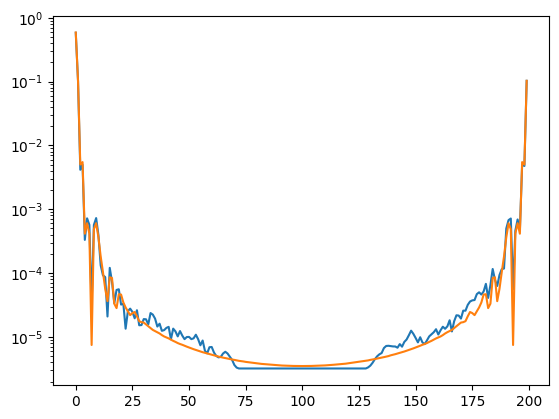

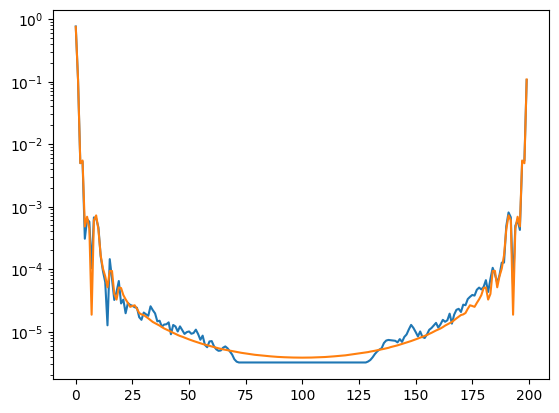

In [12]:
idx=np.random.randint(0,nbatch)

for i in range(h_eff_fft.shape[-1]):
    
    plt.plot(h_eff_fft_reconstruction[idx,0,:,i]**2+h_eff_fft_reconstruction[idx,1,:,i]**2)
    plt.plot(h_eff_fft[idx,0,:,i]**2+h_eff_fft[idx,1,:,i]**2)
    plt.semilogy()
    plt.show()
    

#### (Optional) Fourier filter

In [22]:
h_eff_fft_reconstruction_filter=h_eff_fft_reconstruction.copy()
h_eff_fft_reconstruction_filter[:,:,80:-80]=0.
h_eff_reconstruction_filter=ifft(h_eff_fft_reconstruction_filter[:,0]+1j*h_eff_fft_reconstruction_filter[:,1],norm='forward',axis=1)


#### Test in the time space

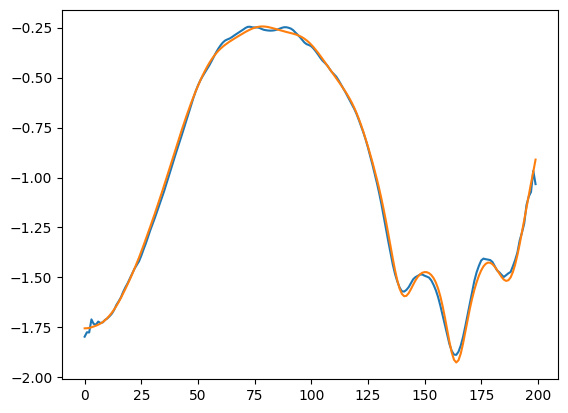

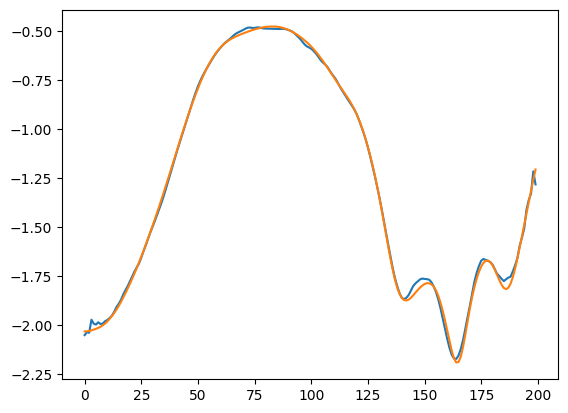

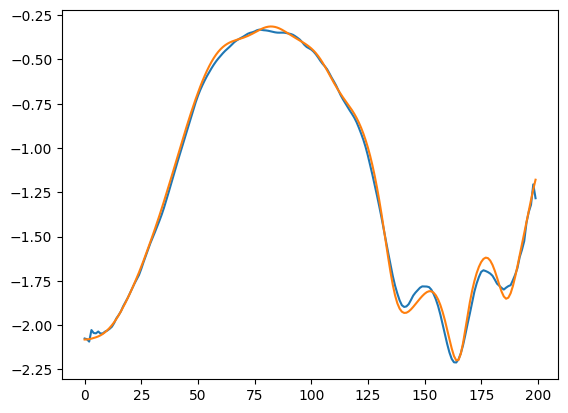

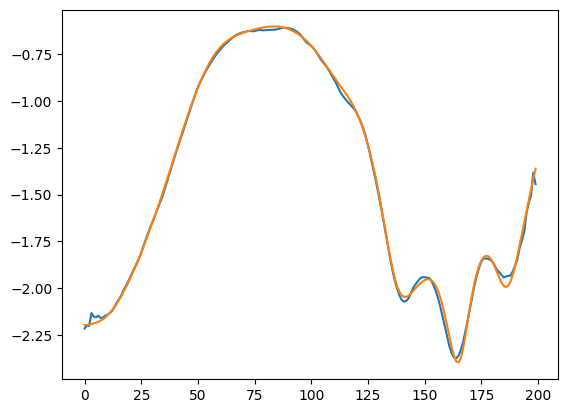

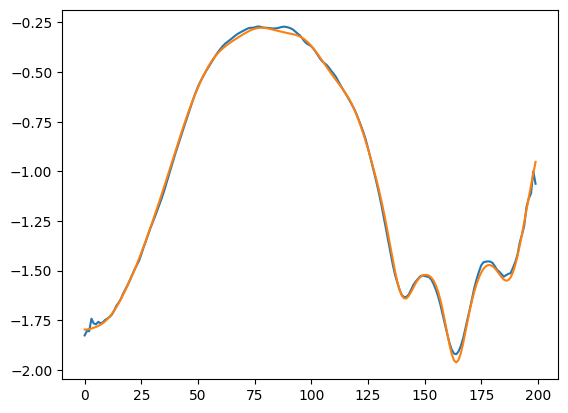

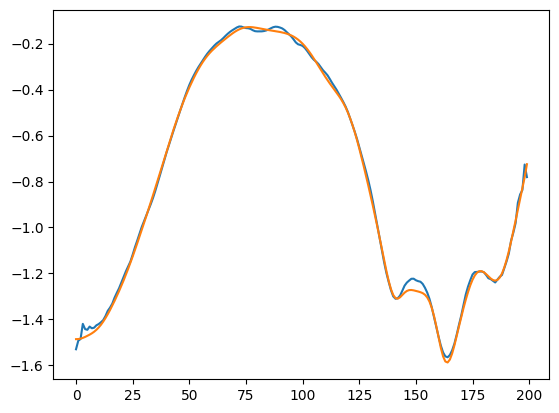

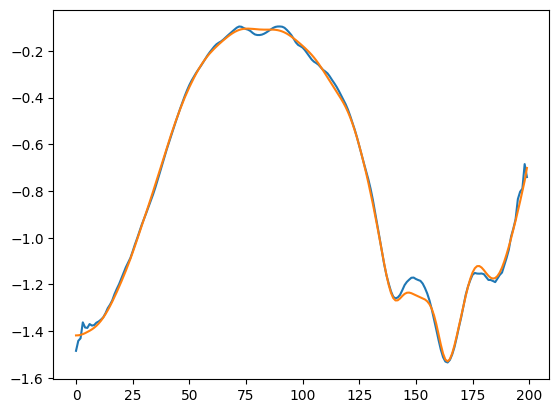

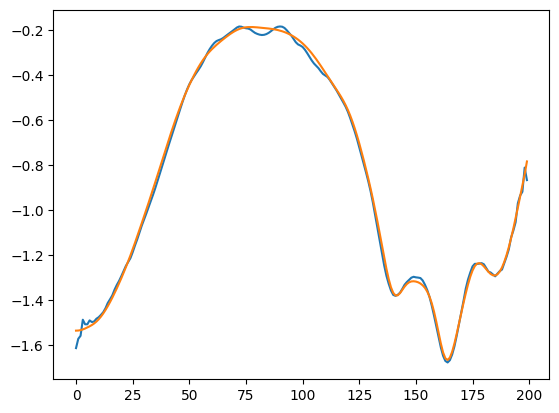

In [23]:

h_eff_reconstruction=ifft(h_eff_fft_reconstruction[:,0]+1j*h_eff_fft_reconstruction[:,1],norm='forward',axis=1)


h_eff=ifft(h_eff_fft[:,0]+1j*h_eff_fft[:,1],norm='forward',axis=1)



for i in range(h_eff.shape[-1]):
    plt.plot(h_eff_reconstruction[idx,:,i])
    plt.plot(h_eff[idx,:,i])
    plt.show()
    



#### (Optional) Reconstruction filter

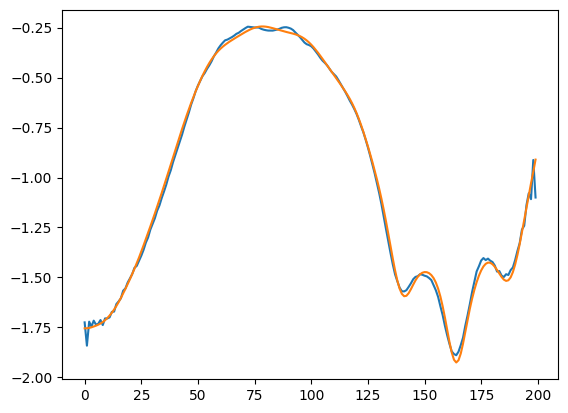

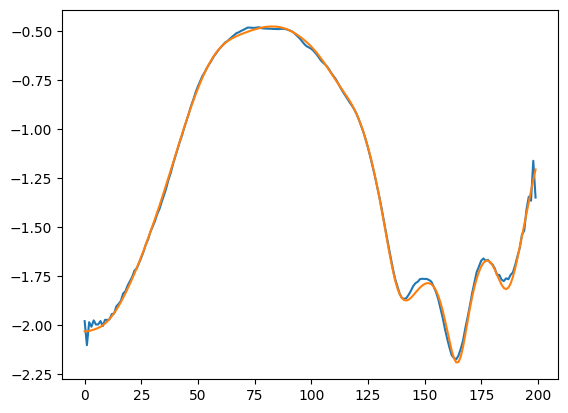

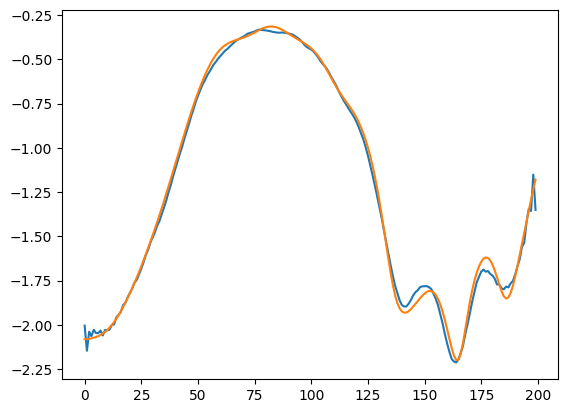

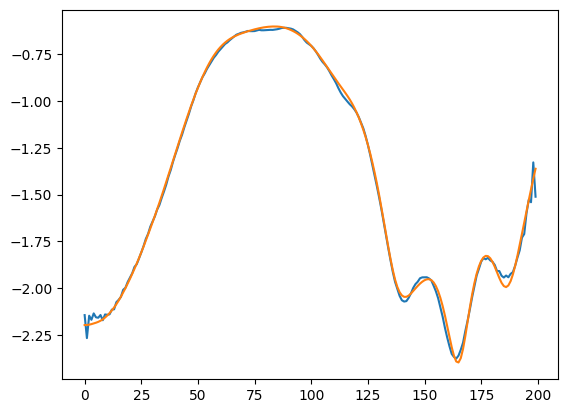

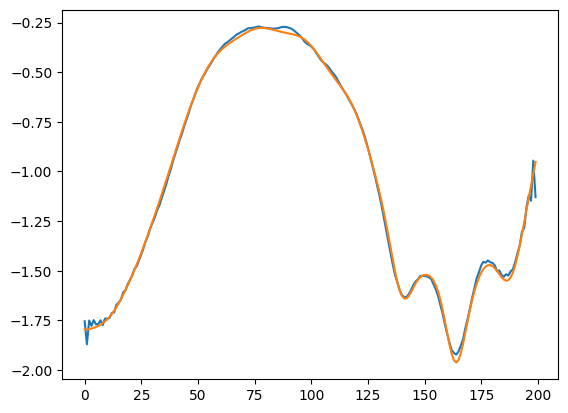

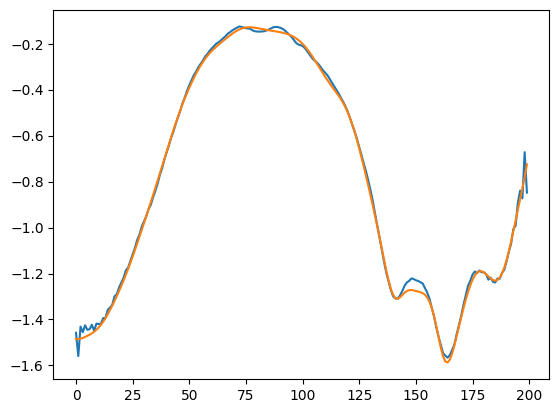

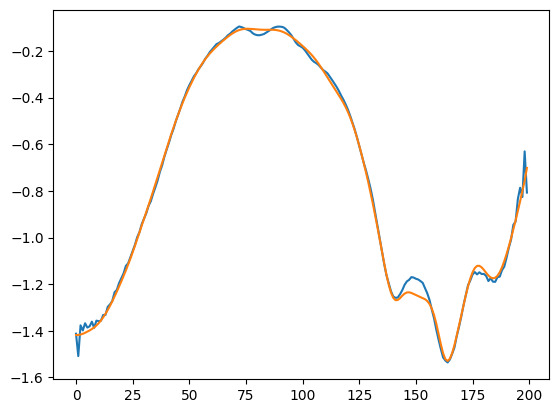

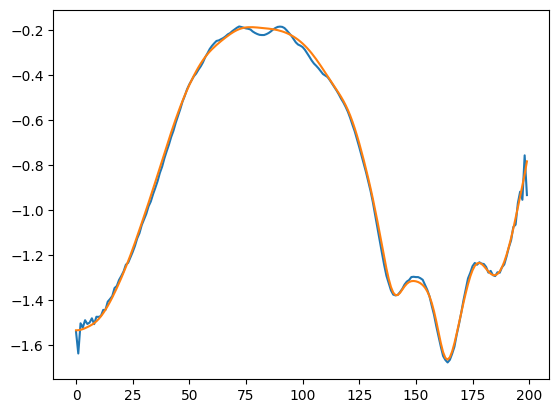

In [24]:

for i in range(h_eff.shape[-1]):
    #plt.plot(h_eff_reconstruction[idx,:,i])
    plt.plot(h_eff_reconstruction_filter[idx,:,i])
    plt.plot(h_eff[idx,:,i])
    plt.show()
    